In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
import shap
import os

# Load dataset
# Set working directory
os.chdir('/Users/jeancherizol/MADS/699/repos/siads699_optimizing_emergency_department_operations')


import numpy as np
import pandas as pd

def apply_log_transform_to_high_variance_features(df, variance_threshold_multiplier=1.5):
    """
    Applies a log transformation to numeric features in a DataFrame that have high variance.
    
    Parameters:
    - df: pandas DataFrame to process.
    - variance_threshold_multiplier: Multiplier to the mean variance to set the threshold for high variance.
    
    Returns:
    - A list of high variance features that were log-transformed.
    """
    # Ensure working with only numeric features
    numeric_df = df.select_dtypes(include=[np.number])
    # Step 1: Calculate the variance of each numeric feature
    variances = numeric_df.var()
    
    # Define a threshold for high variance
    high_variance_threshold = variances.mean() * variance_threshold_multiplier
    
    # Step 2: Identify high-variance features
    high_variance_features = variances[variances > high_variance_threshold].index.tolist()
    
    # Apply log1p transformation to high-variance features
    for feature in high_variance_features:
        # Ensure no negative values or zeroes in the column before log transformation
        if (df[feature] <= 0).any():
            # Shift the feature values to positive if there are non-positive values
            min_positive_value = df[feature].min()
            df[feature] = df[feature] + (min_positive_value * -1) + 1
        df[feature] = np.log1p(df[feature])

    return high_variance_features


def columns_with_multiple_dtypes(df):
    """
    Identifies and returns a list of columns that contain more than one data type.
    
    Parameters:
    - df: pandas DataFrame to check.
    
    Returns:
    - List of column names that have more than one data type.
    """
    columns_with_multiple_types = []

    for column in df.columns:
        unique_types = set(df[column].apply(type))
        if len(unique_types) > 1:
            columns_with_multiple_types.append(column)

    return columns_with_multiple_types


# Load dataset
path = "/Users/jeancherizol/MADS/699/all_data/"
df = pd.read_sas(f"{path}/nhamcs14.sas7bdat")


# Decode bytes to string if necessary and handle absolute values for numeric columns
df = df.apply(lambda x: x.apply(lambda y: y.decode('utf-8') if isinstance(y, bytes) else y))
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_cols] = df[numeric_cols].abs()

# Cap the values to a maximum threshold post-transformation
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = np.clip(df[numeric_cols], a_min=None, a_max=1e15)  # Adjust the max value as needed

# Replace inf/-inf with NaN, then fill NaNs with median of each numeric column
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

# Fill missing values for categorical features with mode
df.fillna(df.select_dtypes(include='object').mode().iloc[0], inplace=True)

# Call the function to apply log transformation to high-variance features
high_variance_features_transformed = apply_log_transform_to_high_variance_features(df)
print("High variance features that were log-transformed:", high_variance_features_transformed)


print("Columns with more than one type of data:", columns_with_multiple_dtypes(df))


# Log transformation of the target variable (WAITTIME) to handle skewness
df['Log_WAITTIME'] = np.log1p(df['WAITTIME'])


# Remove duplicates and rows/columns with all missing values
df.drop_duplicates(inplace=True)
df.dropna(axis=0, how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)

df_filtered = df
# Prepare for model training
# X = df_filtered.drop(columns=['Log_WAITTIME'])
# y = df_filtered['Log_WAITTIME']



# Initialize the PowerTransformer
power_transformer = PowerTransformer(method='yeo-johnson')

# Reshape data for transformation (needs to be 2D)
wait_time_reshaped = df['WAITTIME'].values.reshape(-1, 1)

# Apply the Yeo-Johnson transformation
transformed_wait_time = power_transformer.fit_transform(wait_time_reshaped)

# Replace the original 'WAITTIME' column with the transformed data
df['Transformed_WAITTIME'] = transformed_wait_time

import pandas as pd

def remove_trailing_zeros(df):
    """
    Removes '.0' from the end of values in all DataFrame columns where applicable.
    
    Parameters:
    - df: A pandas DataFrame.
    
    Returns:
    - A DataFrame with modified columns where '.0' endings have been removed.
    """
    for col in df.columns:
        # Check if column is of numeric type
        if pd.api.types.is_numeric_dtype(df[col]):
            # Attempt conversion to integers if all values in column are effectively integers
            if all(df[col].dropna().apply(float.is_integer)):
                df[col] = df[col].astype(int)
    return df


# Apply the function
df = remove_trailing_zeros(df)

#Splits ARRTIME column into ARRTIME_IN_HOUR and ARRTIME_IN_MN columns

def split_arrtime(df):
    """
    Splits ARRTIME column into ARRTIME_IN_HOUR and ARRTIME_IN_MN columns.
    
    Parameters:
    - df: pandas DataFrame with an 'ARRTIME' column consisting of integers or floats.
    
    Returns:
    - DataFrame with two new columns: 'ARRTIME_IN_HOUR' for hours and 'ARRTIME_IN_MN' for minutes.
    """
    # Ensure ARRTIME is treated as a string and pad with zeros to ensure 4 characters
    df['ARRTIME_STR'] = df['ARRTIME'].apply(lambda x: str(int(x)).zfill(4))
    
    # Extract hour and minute parts
    df['ARRTIME_IN_HOUR'] = df['ARRTIME_STR'].str[:2].astype(int)
    df['ARRTIME_IN_MN'] = df['ARRTIME_STR'].str[2:].astype(int)
    
    # Drop the temporary string column
    df.drop(columns=['ARRTIME_STR'], inplace=True)
    
    return df
df = df.copy()
df = split_arrtime(df)


High variance features that were log-transformed: ['CSTRATM']
Columns with more than one type of data: []


In [2]:
# statistical summary to understand the distributions and central tendencies of the variables
print(df[['WAITTIME', 'VMONTH', 'VDAYR', 'ARRTIME_IN_HOUR']].describe())


           WAITTIME        VMONTH         VDAYR  ARRTIME_IN_HOUR
count  23844.000000  23844.000000  23844.000000     23844.000000
mean      35.393013      6.335682      3.939272        13.288626
std       64.359543      3.355561      1.975228         6.178759
min        0.000000      1.000000      1.000000         0.000000
25%        9.000000      3.000000      2.000000        10.000000
50%       15.000000      6.000000      4.000000        14.000000
75%       39.000000      9.000000      6.000000        18.000000
max     1356.000000     12.000000      7.000000        23.000000


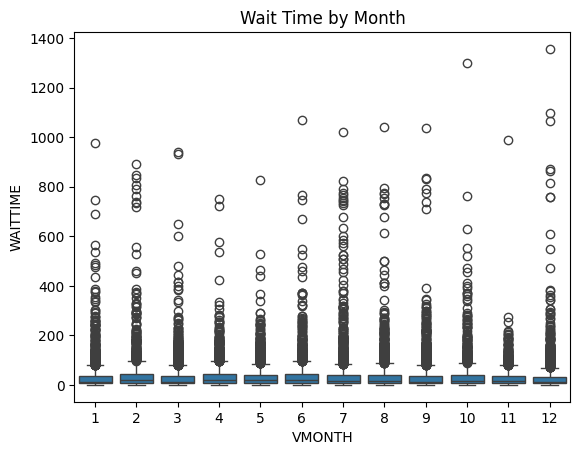

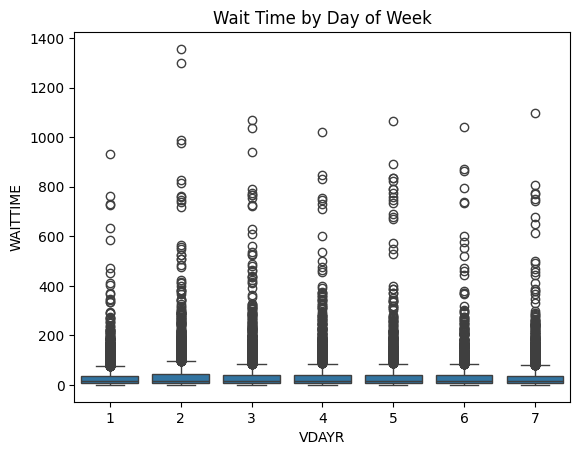

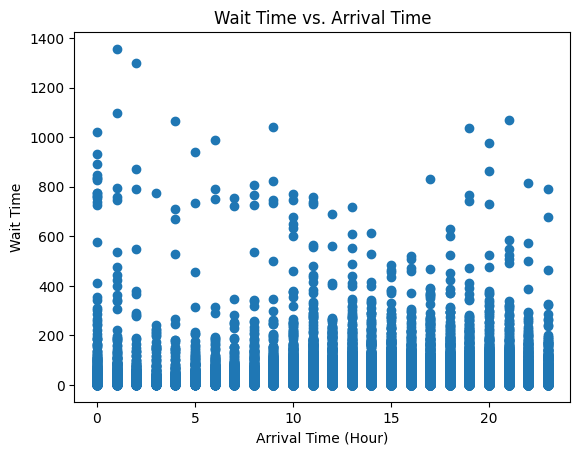

In [3]:
#Visualizations can help identify patterns, trends, and outliers more intuitively.
import seaborn as sns
import matplotlib.pyplot as plt

# WAITTIME BY VMONTH
sns.boxplot(x='VMONTH', y='WAITTIME', data=df)
plt.title('Wait Time by Month')
plt.show()


# WAITTIME BY VDAYR 
sns.boxplot(x='VDAYR', y='WAITTIME', data=df)
plt.title('Wait Time by Day of Week')
plt.show()

# WAITTIME BY ARRTIME_IN_HOUR 
plt.scatter(df['ARRTIME_IN_HOUR'], df['WAITTIME'])
plt.title('Wait Time vs. Arrival Time')
plt.xlabel('Arrival Time (Hour)')
plt.ylabel('Wait Time')
plt.show()


In [4]:
#Check for any linear correlations between WAITTIME and numerical predictors (ARRTIME_IN_HOUR)
print(df[['WAITTIME', 'ARRTIME_IN_HOUR']].corr())

                 WAITTIME  ARRTIME_IN_HOUR
WAITTIME         1.000000         0.023207
ARRTIME_IN_HOUR  0.023207         1.000000


In [5]:
#grouped analysis to see average wait times by month, day, and arrival hour.
print(df.groupby('VMONTH')['WAITTIME'].mean().reset_index(name='Average Wait Time'))
print(df.groupby('VDAYR')['WAITTIME'].mean().reset_index(name='Average Wait Time'))
print(df.groupby('ARRTIME_IN_HOUR')['WAITTIME'].mean().reset_index(name='Average Wait Time'))


    VMONTH  Average Wait Time
0        1          34.208948
1        2          39.586410
2        3          31.933793
3        4          34.373377
4        5          33.912281
5        6          36.969578
6        7          40.802181
7        8          36.350633
8        9          35.429201
9       10          36.786137
10      11          29.551511
11      12          33.871647
   VDAYR  Average Wait Time
0      1          31.160528
1      2          39.964436
2      3          36.778218
3      4          35.382422
4      5          35.542461
5      6          34.139221
6      7          33.849797
    ARRTIME_IN_HOUR  Average Wait Time
0                 0          28.733444
1                 1          43.052846
2                 2          37.627451
3                 3          28.778481
4                 4          36.780769
5                 5          38.119048
6                 6          37.249377
7                 7          27.563025
8                 8          29.294

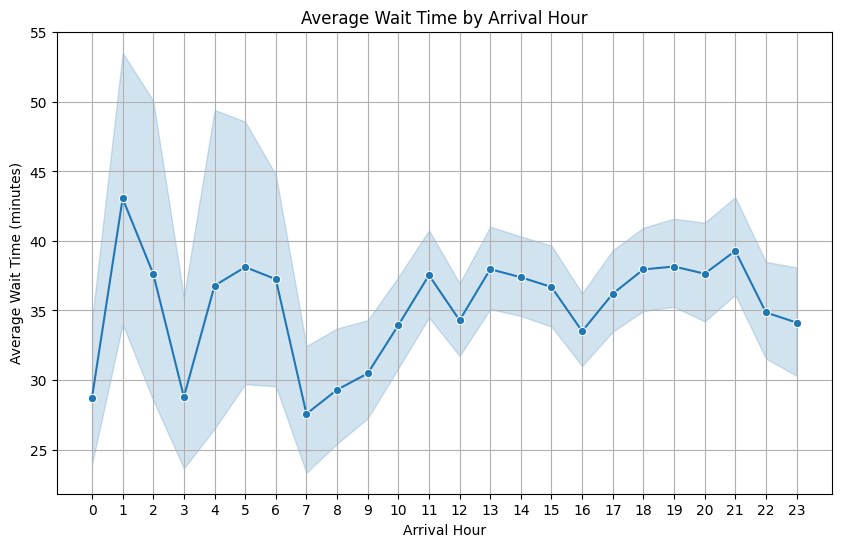

In [6]:
#plot Wait Time by Arrival Hour (ARRTIME_IN_HOUR)
import seaborn as sns
# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='ARRTIME_IN_HOUR', y='WAITTIME', marker='o')
plt.title('Average Wait Time by Arrival Hour')
plt.xlabel('Arrival Hour')
plt.ylabel('Average Wait Time (minutes)')
plt.xticks(range(0, 24))  # Ensure x-axis ticks for every hour
plt.grid(True)
plt.show()


In [7]:
# First, make sure to install Dash with pip install dash

import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd

# Example DataFrame setup
# df = pd.DataFrame({
#     'ARRTIME_IN_HOUR': [10, 11, 12, 13, 14, 15],
#     'WAITTIME': [20, 25, 30, 35, 40, 45]
# })

# Replace the above comment block with your actual DataFrame

# Create a Plotly Express line plot
fig = px.line(df, x='ARRTIME_IN_HOUR', y='WAITTIME', markers=True, title='Average Wait Time by Arrival Hour')
fig.update_layout(xaxis_title='Arrival Hour', yaxis_title='Average Wait Time (minutes)', xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1))

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div(children=[
    html.H1(children='Interactive Dashboard: Wait Time by Arrival Hour'),

    html.Div(children='''
        An interactive line plot showing the average wait time across different arrival hours.
    '''),

    dcc.Graph(
        id='waittime-arrivalhour-plot',
        figure=fig
    )
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


In [8]:
voila Untitled-1-statistque.ipynb


SyntaxError: invalid syntax (1003216730.py, line 1)

In [10]:
df.sample(100)

,VMONTH,VDAYR,ARRTIME,WAITTIME,LOV,AGE,AGER,AGEDAYS,RESIDNCE,SEX,...,RX30V3C1,SETTYPE,YEAR,CSTRATM,CPSUM,PATWT,Log_WAITTIME,Transformed_WAITTIME,ARRTIME_IN_HOUR,ARRTIME_IN_MN
15250,7,4,1431,18,183,64,4,7,1,1,...,215,3,2014,17.509378,16,4073,2.944439,0.040255,14,31
19339,7,1,1829,56,111,13,1,7,1,2,...,215,3,2014,17.511862,32,3527,4.043051,0.968565,18,29
10670,10,4,2252,78,134,11,1,7,1,1,...,215,3,2014,16.831741,100228,25146,4.369448,1.249069,22,52
319,2,6,1424,292,431,58,4,7,1,1,...,215,3,2014,16.821896,100103,2366,5.680173,2.397680,14,24
4932,3,1,1628,25,207,18,2,7,1,1,...,215,3,2014,16.821896,100076,2162,3.258097,0.302822,16,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3970,6,5,1034,76,266,39,3,7,1,2,...,215,3,2014,16.821896,100092,3337,4.343805,1.226953,10,34
451,7,5,2050,191,320,26,3,7,1,2,...,215,3,2014,16.826831,100180,1920,5.257495,2.023364,20,50
11282,5,2,1519,9,94,19,2,7,1,1,...,215,3,2014,17.506887,3,5476,2.302585,-0.490986,15,19
7096,2,4,1545,22,3215,27,3,7,1,2,...,215,3,2014,16.826831,100171,2740,3.135494,0.199957,15,45


In [ ]:
# Now you can proceed to split your dataset
X = df.drop(columns=['WAITTIME', 'Transformed_WAITTIME','Log_WAITTIME'])  # Assuming 'WAITTIME' should still be dropped
y = df['Transformed_WAITTIME']

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing for numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('polynomial', PolynomialFeatures(degree=2, include_bias=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='drop'
)


In [ ]:


# Define models and their parameter grids
models_params = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [1.0, 10.0]
        }
    },
    # 'Lasso': {
    #     'model': Lasso(),
    #     'params': {
    #         'alpha': [0.1, 1.0, 10.0]
    #     }
    # },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'min_samples_split': [2, 5, 10]
        }
    },
    'XGBRegressor': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6]
        }
    },
    'LGBMRegressor': {
        'model': LGBMRegressor(random_state=42, force_col_wise=True, verbosity=-1),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [31, 62]
        }
    },
    'CatBoostRegressor': {
        'model': CatBoostRegressor(random_state=42, verbose=0),
        'params': {
            'iterations': [100, 200],
            'learning_rate': [0.01, 0.1],
            'depth': [4, 6]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=42),
        'params': {
            'alpha': [0.1, 1.0, 10.0],
            'l1_ratio': [0.2, 0.5, 0.8]
        }
    },
    'MLPRegressor': {
        'model': MLPRegressor(random_state=42, early_stopping=True, max_iter=500,),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd'],
            'alpha': [0.0001, 0.001],
            'learning_rate': ['constant', 'adaptive'],
            'learning_rate_init': [0.001, 0.01],  # Adjust initial learning rate
            
        }
    }

}


In [ ]:

# Iterate and evaluate models
for model_name, model_info in models_params.items():
    model = model_info['model']
    param_distributions = {f'regressor__{k}': v for k, v in model_info['params'].items()}
    
    # Set up the feature selection using the current model
    feature_selection_model = model_info['model']
    feature_selection = SelectFromModel(estimator=feature_selection_model)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
        ('pca', PCA(n_components=2)), 
        ('feature_selection', SelectKBest(score_func=f_regression, k=50)),  
        # ('feature_selection', RFECV(estimator=RandomForestRegressor(), step=1, cv=5, scoring='neg_mean_squared_error')),  
        # ('feature_selection',SelectFromModel(RandomForestRegressor(random_state=42))),
        # ('feature_selection', feature_selection),
        ('regressor', model)
    ])


    total_combinations = int(np.prod([len(v) for v in param_distributions.values()]))

    search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=min(10, total_combinations), 
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42 
    )

    search.fit(X_train, y_train)
    best_pipeline = search.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    # Correctly reverse the log transformation for evaluation
    # y_pred_original = np.expm1(y_pred)
    # y_test_original = np.expm1(y_test)
    y_pred_original = power_transformer.inverse_transform(y_pred.reshape(-1, 1))
    y_test_original = power_transformer.inverse_transform(y_test.reshape(-1, 1))
    
    print(f"Model: {model_name}, "
          f"MAE: {mean_absolute_error(y_test_original, y_pred_original)}, "
          f"MSE: {mean_squared_error(y_test_original, y_pred_original)}, "
          f"RMSE: {np.sqrt(mean_squared_error(y_test_original, y_pred_original))}, "
          f"R^2: {r2_score(y_test_original, y_pred_original)}")
